In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import seaborn as sns
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

In [164]:
!nvidia-smi

Wed Jun 11 18:29:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             32W /  250W |    8511MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [165]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.18.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
IMG_SIZE = 150

data_augmentation = tfk.Sequential([
    tfkl.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tfkl.Rescaling(1./255),
    tfkl.RandomRotation(0.10),
    tfkl.RandomHeight(0.1),          
    tfkl.RandomFlip("horizontal_and_vertical")
])

model = tfk.Sequential([
    tfkl.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,
    tfkl.Conv2D(32, kernel_size=3, strides=1, kernel_regularizer=l2(0.0001)),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.MaxPool2D(),
    tfkl.Conv2D(128, kernel_size=3, strides=1, kernel_regularizer=l2(0.0001)),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.MaxPool2D(),
    tfkl.Conv2D(256, kernel_size=3, strides=1),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.MaxPool2D(),
    tfkl.GlobalAveragePooling2D(),
    tfkl.Dense(128),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.Dropout(0.5),
    tfkl.Dense(256),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.Dense(1, activation="sigmoid")
])

/opt/homebrew/Caskroom/miniforge/base/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
TRAIN_PATH = "./cell_images_split/train"
TEST_PATH = "./cell_images_split/test"
VAL_PATH = "./cell_images_split/val"

TRAIN_SIZE = 0.80
TEST_SIZE = 0.10
VAL_SIZE = 0.10
SEED=22
BATCH_SIZE=64


# load datasets
train_gen = image_dataset_from_directory(
    TRAIN_PATH,
    labels='inferred',
    color_mode="rgb",
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED
)

val_gen = image_dataset_from_directory(
    VAL_PATH,
    labels='inferred',
    color_mode="rgb",
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

test_gen = image_dataset_from_directory(
    TEST_PATH,
    labels='inferred',
    color_mode="rgb",
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

class_names = train_gen.class_names

AUTOTUNE = tf.data.AUTOTUNE

print(class_names)

train_gen = train_gen.cache().prefetch(buffer_size=AUTOTUNE)
val_gen = val_gen.cache().prefetch(buffer_size=AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=AUTOTUNE)

Found 22046 files belonging to 2 classes.
Found 2756 files belonging to 2 classes.
Found 2756 files belonging to 2 classes.
['A. Uninfected', 'B. Parasitized']


Model compilation definitions...

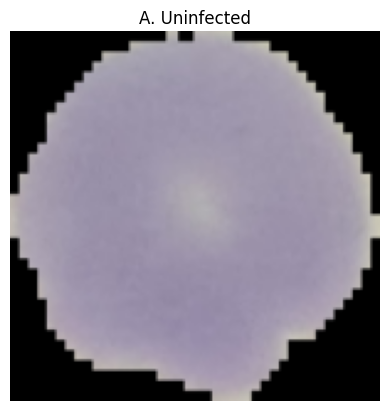

In [168]:
# visualise one image
for img, lab in train_gen.shuffle(BATCH_SIZE).take(1):
    plt.imshow(img[0].numpy().astype("uint8"))
    plt.title(f"{class_names[int(lab[0])]}")
    plt.axis("off")
    plt.show()
    break


In [169]:
n_epochs = 40

model_callbacks = [
    tfk.callbacks.ReduceLROnPlateau(patience=3, factor=0.15, verbose=1, min_lr=1e-10), 
    tfk.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=9,verbose=1,mode="auto"
)]

model.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=1e-3),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[tfk.metrics.BinaryAccuracy()]
)

In [170]:
print(model.summary())

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_45 (Sequential)           │ (None, None, 150, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, None, 148, 32)       │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_118              │ (None, None, 148, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_118 (ReLU)                     │ (None, None, 148, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_72 (MaxPooling2D)      │ (None, None, 74, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, None, 72, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_119              │ (None, None, 72, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_119 (ReLU)                     │ (None, None, 72, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_73 (MaxPooling2D)      │ (None, None, 36, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, None, 34, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_120              │ (None, None, 34, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_120 (ReLU)                     │ (None, None, 34, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ (None, None, 17, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_13          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_121              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_121 (ReLU)                     │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 256)                 │          33,0

 Total params: 402,433 (1.54 MB)

 Trainable params: 400,833 (1.53 MB)

 Non-trainable params: 1,600 (6.25 KB)

None


In [171]:
history = model.fit(train_gen, validation_data=test_gen, epochs=n_epochs, callbacks=model_callbacks)

Epoch 1/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - binary_accuracy: 0.8003 - loss: 0.4330 - val_binary_accuracy: 0.5290 - val_loss: 2.0220 - learning_rate: 0.0010
Epoch 2/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - binary_accuracy: 0.9185 - loss: 0.2353 - val_binary_accuracy: 0.8806 - val_loss: 0.3162 - learning_rate: 0.0010
Epoch 3/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - binary_accuracy: 0.9325 - loss: 0.2019 - val_binary_accuracy: 0.9343 - val_loss: 0.1987 - learning_rate: 0.0010
Epoch 4/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - binary_accuracy: 0.9384 - loss: 0.1861 - val_binary_accuracy: 0.9496 - val_loss: 0.1502 - learning_rate: 0.0010
Epoch 5/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - binary_accuracy: 0.9392 - loss: 0.1773 - val_binary_accuracy: 0.9492 - val_loss: 0.1801 - learning_rate: 0.0010
Epoch 6/40
345/345 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - binary_accuracy: 0.9430 - loss: 0.1739 - val_binary_accuracy: 0.9539 - val_loss: 0.1401 - learning_rate:

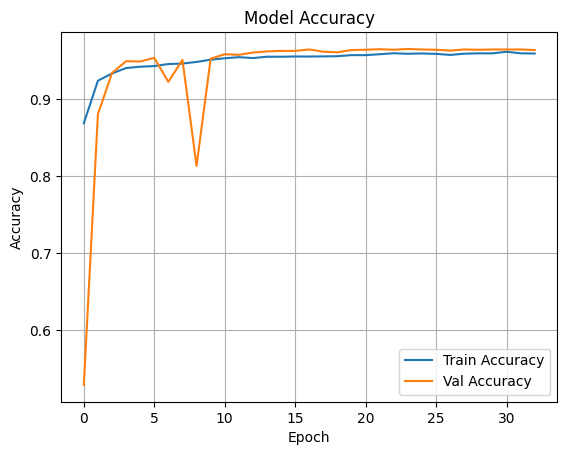

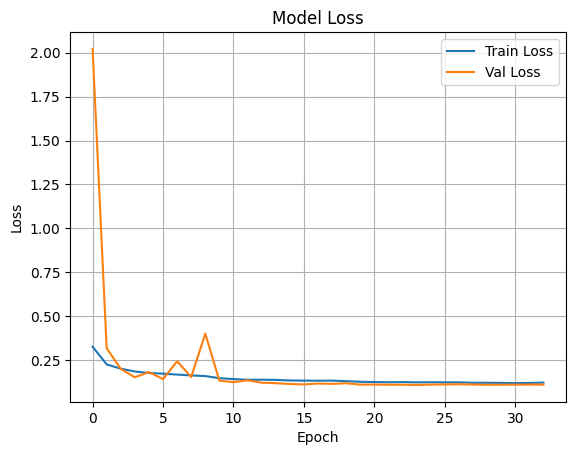

In [172]:
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [182]:
# inference on unseen data...
val_loss, val_accuracy = model.evaluate(val_gen)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.9634 - loss: 0.1067
Validation Loss: 0.1227
Validation Accuracy: 0.9568


In [183]:
preds = model.predict(val_gen)
y_pred = preds.round().astype(int).flatten()

true_labels = []
for _, labels in val_gen:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels).astype(int)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [184]:
# get the classification report for unseen data
print(classification_report(true_labels, y_pred, target_names=class_names))

                precision    recall  f1-score   support

 A. Uninfected       0.94      0.97      0.96      1378
B. Parasitized       0.97      0.94      0.96      1378

      accuracy                           0.96      2756
     macro avg       0.96      0.96      0.96      2756
  weighted avg       0.96      0.96      0.96      2756



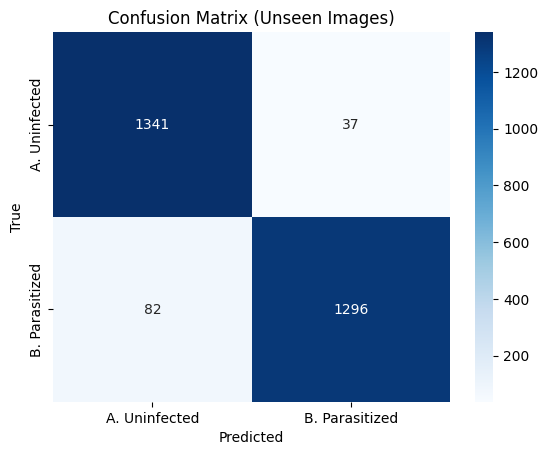

In [185]:
cm = confusion_matrix(true_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Unseen Images)')
plt.show()

In [186]:
model.save("malaria_classifier.keras")